In [21]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import datasets
from torchvision.transforms import ToTensor

## Loads Relevant Dataset

In [22]:

train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

## Prepare Dataset

In [30]:
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7fb0790273a0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7fb06aded370>}

## Inspects Dimension of Data

In [23]:
print(f'Size of test set: {test_data.data.size()}')
print(f'Size of training set: {train_data.data.size()}')

Size of test set: torch.Size([10000, 28, 28])
Size of training set: torch.Size([60000, 28, 28])


## Visualize Dataset

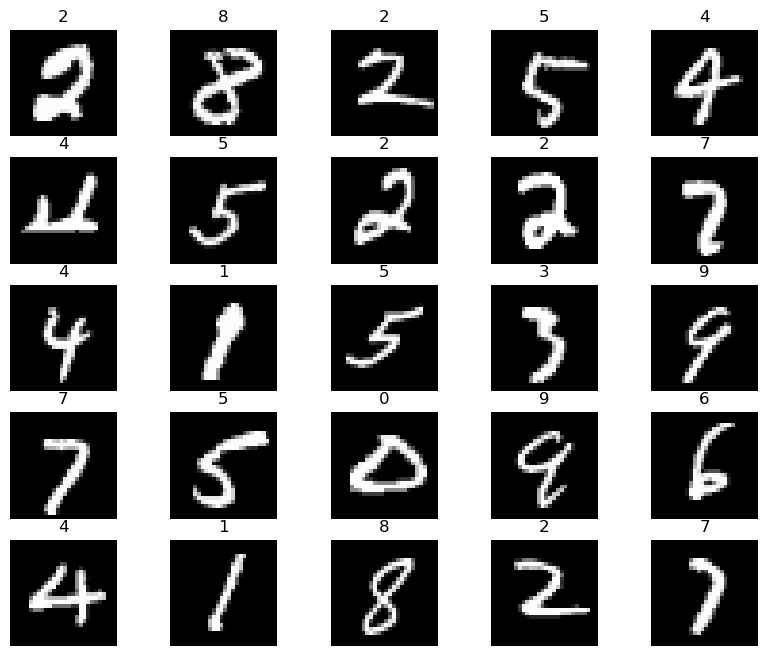

In [24]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [25]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    


In [26]:
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [27]:
loss_func = nn.CrossEntropyLoss()   


In [28]:
from torch import optim
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)   
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.01
    maximize: False
    weight_decay: 0
)

In [31]:
from torch.autograd import Variable
num_epochs = 10
def train(num_epochs, cnn, loaders):
    cnn.train()
    total_step = len(loaders['train'])
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            b_x = Variable(images)   
            b_y = Variable(labels)   
            output = cnn(b_x)[0]               
            loss = loss_func(output, b_y)  
            optimizer.zero_grad()           
            loss.backward()               
            optimizer.step()                
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
                pass
        pass
    pass
train(num_epochs, cnn, loaders)

Epoch [1/10], Step [100/600], Loss: 0.0328
Epoch [1/10], Step [200/600], Loss: 0.1403
Epoch [1/10], Step [300/600], Loss: 0.0268
Epoch [1/10], Step [400/600], Loss: 0.0206
Epoch [1/10], Step [500/600], Loss: 0.0140
Epoch [1/10], Step [600/600], Loss: 0.0473
Epoch [2/10], Step [100/600], Loss: 0.0484
Epoch [2/10], Step [200/600], Loss: 0.1383
Epoch [2/10], Step [300/600], Loss: 0.0711
Epoch [2/10], Step [400/600], Loss: 0.0397
Epoch [2/10], Step [500/600], Loss: 0.0874
Epoch [2/10], Step [600/600], Loss: 0.0694
Epoch [3/10], Step [100/600], Loss: 0.1267
Epoch [3/10], Step [200/600], Loss: 0.0224
Epoch [3/10], Step [300/600], Loss: 0.0638
Epoch [3/10], Step [400/600], Loss: 0.0968
Epoch [3/10], Step [500/600], Loss: 0.0074
Epoch [3/10], Step [600/600], Loss: 0.0647
Epoch [4/10], Step [100/600], Loss: 0.0235
Epoch [4/10], Step [200/600], Loss: 0.0248
Epoch [4/10], Step [300/600], Loss: 0.0722
Epoch [4/10], Step [400/600], Loss: 0.0098
Epoch [4/10], Step [500/600], Loss: 0.0402
Epoch [4/10

In [32]:
sample = next(iter(loaders['test']))
imgs, lbls = sample

In [33]:
actual_number = lbls[:10].numpy()
actual_number

array([3, 8, 7, 6, 7, 6, 1, 5, 6, 8])

In [34]:
test_output, last_layer = cnn(imgs[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(f'Prediction number: {pred_y}')
print(f'Actual number: {actual_number}')

Prediction number: [3 8 7 6 7 6 1 5 6 8]
Actual number: [3 8 7 6 7 6 1 5 6 8]
